## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import keras
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
SIZE_X = 128
SIZE_Y = 128
SIZE_Z = 1
CLASS_NUM = 6

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_val_DF_{}.pkl".format(SIZE_X))
aug_test_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_test_DF_{}.pkl".format(SIZE_X))

In [3]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
5148,HF1551,Glioma II,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
3661,Heatly_dataset_#998,No tumor,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",no723.jpg
1690,97416,Pituitary,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",1579.mat
15259,112746,Pituitary,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1259.mat
12824,HF1381,Glioma II,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...


In [4]:
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PID     18612 non-null  object
 1   Label   18612 non-null  object
 2   Image   18612 non-null  object
 3   File    18612 non-null  object
dtypes: object(4)
memory usage: 581.8+ KB


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


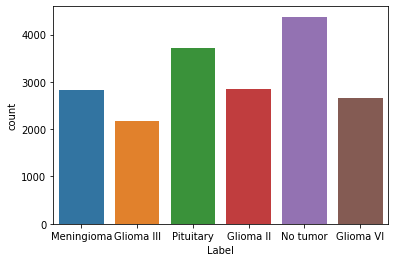

In [5]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

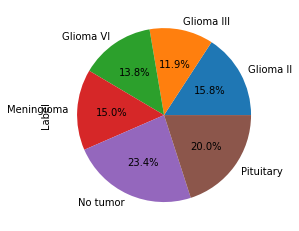

In [6]:
data = aug_train_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

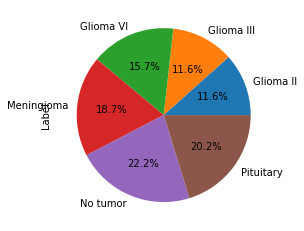

In [7]:
data = aug_val_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

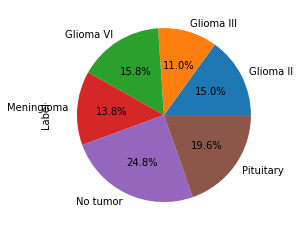

In [8]:
data = aug_test_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [9]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, SIZE_Z]

In [10]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [11]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


In [12]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960,)
X_val shape  : (1860, 128, 128, 1)  | y_test shape :  (1860,)
X_test shape : (2792, 128, 128, 1)  | y_test shape :  (2792,)


### 2.5 One-Hot Encode the labels 

In [13]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [14]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960, 6)
X_test shape : (2792, 128, 128, 1)  | y_test shape:  (2792, 6)
X_val shape  : (1860, 128, 128, 1)  | y_val shape :  (1860, 6)

Total number: 18612


In [15]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,No tumor,Pituitary
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
2787,0,0,0,0,0,1
2788,0,0,0,0,0,1
2789,0,0,0,0,1,0
2790,0,1,0,0,0,0


### 2.6 Image Normalizatoin

In [16]:
X_train = X_train / 255
X_val   = X_val / 255
X_test  = X_test / 255

In [17]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "No tumor", 5: "Pituitary"}

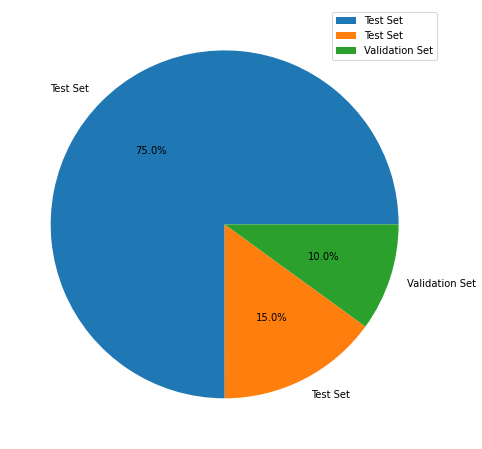

In [18]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [19]:
m1 = Sequential()
m1.add(Conv2D(input_shape=(SIZE_X , SIZE_Y, SIZE_Z),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
m1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
m1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
m1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
m1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

m1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
m1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
m1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
m1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

m1.add(Flatten())
m1.add(Dense(CLASS_NUM, activation='softmax'))

m1.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)       5

### 4. Model Training


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 23 )

m1.fit(X_train,y_train,epochs=150,batch_size=32, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/150
437/437 [==============================] - 70s 146ms/step - loss: 0.8074 - accuracy: 0.6877 - val_loss: 0.5787 - val_accuracy: 0.7935
Epoch 2/150
437/437 [==============================] - 61s 140ms/step - loss: 0.3666 - accuracy: 0.8665 - val_loss: 0.4301 - val_accuracy: 0.8204
Epoch 3/150
437/437 [==============================] - 61s 140ms/step - loss: 0.2072 - accuracy: 0.9239 - val_loss: 0.4059 - val_accuracy: 0.8516
Epoch 4/150
437/437 [==============================] - 61s 140ms/step - loss: 0.1202 - accuracy: 0.9577 - val_loss: 0.4838 - val_accuracy: 0.8532
Epoch 5/150
437/437 [==============================] - 61s 140ms/step - loss: 0.0841 - accuracy: 0.9715 - val_loss: 0.7641 - val_accuracy: 0.8441
Epoch 6/150
437/437 [==============================] - 61s 140ms/step - loss: 0.0593 - accuracy: 0.9795 - val_loss: 0.7307 - val_accuracy: 0.8538
Epoch 7/150
437/437 [==============================] - 61s 140ms/step - loss: 0.0479 - accuracy: 0.9837 - val_loss: 0.6891 -

437/437 [==============================] - 58s 133ms/step - loss: 4.4593e-07 - accuracy: 1.0000 - val_loss: 1.5774 - val_accuracy: 0.8694
Epoch 57/150
437/437 [==============================] - 58s 133ms/step - loss: 3.5717e-07 - accuracy: 1.0000 - val_loss: 1.5944 - val_accuracy: 0.8683
Epoch 58/150
437/437 [==============================] - 58s 134ms/step - loss: 2.8576e-07 - accuracy: 1.0000 - val_loss: 1.6116 - val_accuracy: 0.8683
Epoch 59/150
437/437 [==============================] - 58s 133ms/step - loss: 2.2793e-07 - accuracy: 1.0000 - val_loss: 1.6302 - val_accuracy: 0.8699
Epoch 60/150
437/437 [==============================] - 58s 133ms/step - loss: 1.8225e-07 - accuracy: 1.0000 - val_loss: 1.6498 - val_accuracy: 0.8710
Epoch 61/150
437/437 [==============================] - 58s 133ms/step - loss: 1.4507e-07 - accuracy: 1.0000 - val_loss: 1.6706 - val_accuracy: 0.8710
Epoch 62/150
437/437 [==============================] - 59s 134ms/step - loss: 1.1525e-07 - accuracy: 1.000

437/437 [==============================] - 88s 202ms/step - loss: 1.0603e-04 - accuracy: 1.0000 - val_loss: 1.2700 - val_accuracy: 0.8817
Epoch 111/150
437/437 [==============================] - 86s 196ms/step - loss: 2.1582e-05 - accuracy: 1.0000 - val_loss: 1.2672 - val_accuracy: 0.8849
Epoch 112/150
437/437 [==============================] - 87s 198ms/step - loss: 6.8898e-06 - accuracy: 1.0000 - val_loss: 1.2774 - val_accuracy: 0.8844
Epoch 113/150
437/437 [==============================] - 89s 204ms/step - loss: 5.0185e-06 - accuracy: 1.0000 - val_loss: 1.2895 - val_accuracy: 0.8833
Epoch 114/150
437/437 [==============================] - 94s 215ms/step - loss: 3.8623e-06 - accuracy: 1.0000 - val_loss: 1.3025 - val_accuracy: 0.8828
Epoch 115/150
437/437 [==============================] - 84s 192ms/step - loss: 3.0414e-06 - accuracy: 1.0000 - val_loss: 1.3167 - val_accuracy: 0.8823
Epoch 116/150
437/437 [==============================] - 87s 199ms/step - loss: 2.3891e-06 - accuracy:

In [21]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [22]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [23]:
print(results)

./experiments/exp#3\results


In [24]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

88/88 [==============================] - 5s 57ms/step - loss: 1.7678 - accuracy: 0.8546


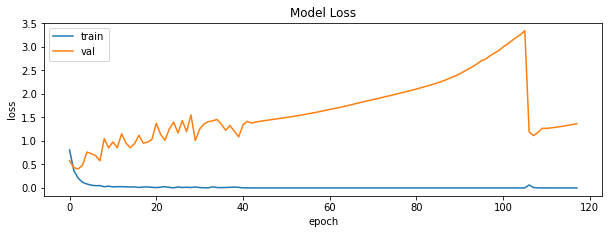

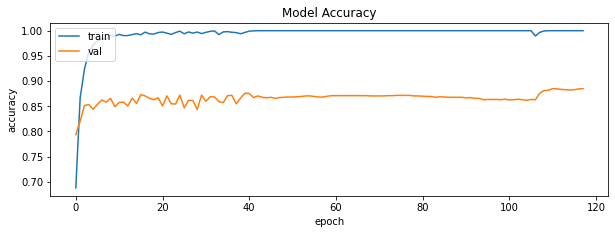

In [25]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [26]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [27]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [28]:
print(classification_report(y_test_eval, predictions))

              precision    recall  f1-score   support

   Glioma II       0.70      0.74      0.72       420
  Glioma III       0.69      0.75      0.72       308
   Glioma VI       0.80      0.69      0.74       440
  Meningioma       0.93      0.89      0.91       384
    No tumor       0.98      0.98      0.98       692
   Pituitary       0.91      0.96      0.93       548

    accuracy                           0.85      2792
   macro avg       0.83      0.83      0.83      2792
weighted avg       0.86      0.85      0.85      2792



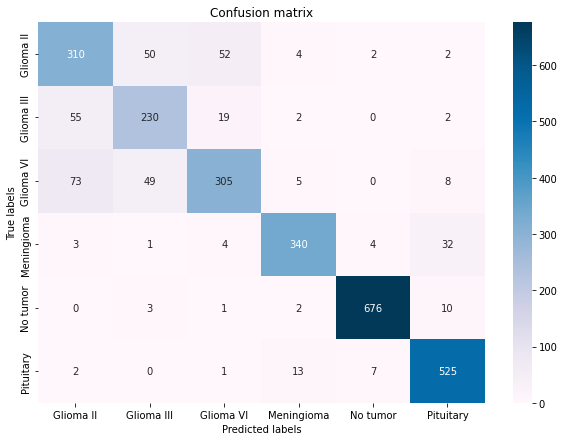

In [29]:
labels = sorted(aug_test_DF.Label.unique())

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()